In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!rm DeconvModels.py
!rm training_functions.py
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Models/DeconvModels.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/training_functions.py -q
from DeconvModels import Deconv2D
from training_functions import train_regression_model, train_classification_model

rm: cannot remove 'DeconvModels.py': No such file or directory
rm: cannot remove 'training_functions.py': No such file or directory


In [ ]:
import numpy as np

def gaussian_kernel(kernel_size, sigma=1):
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2

    for x in range(0, kernel_size):
        for y in range(0, kernel_size):
            x_val = x - center
            y_val = y - center
            kernel[x, y] = np.exp(-(x_val ** 2 + y_val ** 2) / (2 * (sigma ** 2)))

    return kernel / np.sum(kernel)


def blur_images(img, size=5):

    # 4 factor blur
    w = torch.tensor(gaussian_kernel(size), dtype=torch.float32)

    hm1 = nn.functional.pad(w, (0, img.size(-1)-w.size(-1), 0, img.size(-2)-w.size(-2)))

    gm1f = fft2(hm1)

    gmf = gm1f

    ymf = gmf*fft2(img)

    X = ifft2(ymf).real

    return X

In [ ]:
gaussian_kernel(3)

array([[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/data/DIV2K/'

Mounted at /content/drive


In [ ]:
class GoproSynthetic(Dataset):
    def __init__(self, ds_path):
        self.ds_path = ds_path

        y_imgs = os.listdir(f'{ds_path}/LR_bicubic_X2')[:20]

        self.y_paths = list(map(lambda img_path: f'{ds_path}/LR_bicubic_X2/{img_path}', y_imgs))

    
    def __len__(self):
        return len(self.y_paths)


    def __getitem__(self, idx):
        y_path = self.y_paths[idx]

        # x_img = io.read_image(x_path, io.ImageReadMode.GRAY)
        y_img = io.read_image(y_path, io.ImageReadMode.GRAY)

        SIZE = 128
        PAD_SIZE = SIZE//4

        # Preprocess image
        y_img = T.Resize((SIZE, SIZE))(y_img)
        y_img = y_img / 255.0
        y_img = nn.functional.pad(y_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        # Preprocess image
        x_img = blur_images(y_img)

        return x_img, y_img

In [ ]:
data = GoproSynthetic(ds_path=base_path)

data_len = len(data)
dataloader = DataLoader(data, batch_size=16, shuffle=False)

data_len

20

(-0.5, 191.5, 191.5, -0.5)

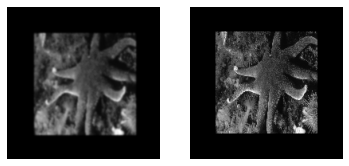

In [ ]:
blur_img, unblur_img = next(iter(dataloader))

plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(blur_img[0, 0, :, :],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(unblur_img[0, 0, :, :],cmap='gray')
plt.axis('off')

In [ ]:
model = Deconv2D((4, 4))

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [ ]:
train_regression_model(model, criterion, optimizer, dataloader, num_epochs=300)

100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Epoch 0001 loss: 0.03769


100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


Epoch 0002 loss: 0.03634


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0003 loss: 0.03469


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0004 loss: 0.03497


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0005 loss: 0.03456


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0006 loss: 0.03286


100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 0007 loss: 0.03375


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0008 loss: 0.03220


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0009 loss: 0.03271


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 0010 loss: 0.03217


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 0011 loss: 0.03168


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 0012 loss: 0.03182


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 0013 loss: 0.03119


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 0014 loss: 0.03132


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Epoch 0015 loss: 0.03096


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0016 loss: 0.03081


100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 0017 loss: 0.03070


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0018 loss: 0.03046


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0019 loss: 0.03044


100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 0020 loss: 0.03021


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0021 loss: 0.03017


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0022 loss: 0.03000


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0023 loss: 0.02994


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0024 loss: 0.02982


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0025 loss: 0.02975


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0026 loss: 0.02966


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0027 loss: 0.02958


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


Epoch 0028 loss: 0.02951


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 0029 loss: 0.02944


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 0030 loss: 0.02938


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 0031 loss: 0.02932


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Epoch 0032 loss: 0.02926


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0033 loss: 0.02921


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0034 loss: 0.02916


100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Epoch 0035 loss: 0.02911


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0036 loss: 0.02907


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0037 loss: 0.02902


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 0038 loss: 0.02898


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0039 loss: 0.02895


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 0040 loss: 0.02891


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0041 loss: 0.02888


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0042 loss: 0.02884


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 0043 loss: 0.02881


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0044 loss: 0.02878


100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


Epoch 0045 loss: 0.02875


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 0046 loss: 0.02873


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 0047 loss: 0.02870


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 0048 loss: 0.02867


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 0049 loss: 0.02865


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Epoch 0050 loss: 0.02863


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Epoch 0051 loss: 0.02861


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0052 loss: 0.02859


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Epoch 0053 loss: 0.02857


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0054 loss: 0.02855


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0055 loss: 0.02853


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch 0056 loss: 0.02851


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Epoch 0057 loss: 0.02849


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0058 loss: 0.02848


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 0059 loss: 0.02846


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Epoch 0060 loss: 0.02844


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0061 loss: 0.02843


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch 0062 loss: 0.02842


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 0063 loss: 0.02840


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Epoch 0064 loss: 0.02839


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 0065 loss: 0.02838


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 0066 loss: 0.02836


100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Epoch 0067 loss: 0.02835


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0068 loss: 0.02834


100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 0069 loss: 0.02833


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0070 loss: 0.02832


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0071 loss: 0.02831


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0072 loss: 0.02830


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0073 loss: 0.02829


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0074 loss: 0.02828


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0075 loss: 0.02827


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Epoch 0076 loss: 0.02826


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0077 loss: 0.02825


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 0078 loss: 0.02824


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0079 loss: 0.02823


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


Epoch 0080 loss: 0.02822


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 0081 loss: 0.02822


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 0082 loss: 0.02821


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 0083 loss: 0.02820


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch 0084 loss: 0.02819


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0085 loss: 0.02818


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0086 loss: 0.02818


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0087 loss: 0.02817


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Epoch 0088 loss: 0.02816


100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch 0089 loss: 0.02816


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0090 loss: 0.02815


100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 0091 loss: 0.02814


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0092 loss: 0.02814


100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 0093 loss: 0.02813


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0094 loss: 0.02813


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0095 loss: 0.02812


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0096 loss: 0.02811


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0097 loss: 0.02811


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 0098 loss: 0.02810


100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Epoch 0099 loss: 0.02810


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 0100 loss: 0.02809


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 0101 loss: 0.02809


100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


Epoch 0102 loss: 0.02808


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0103 loss: 0.02808


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0104 loss: 0.02807


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0105 loss: 0.02807


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0106 loss: 0.02806


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0107 loss: 0.02806


100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


Epoch 0108 loss: 0.02805


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0109 loss: 0.02805


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0110 loss: 0.02804


100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 0111 loss: 0.02804


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 0112 loss: 0.02803


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0113 loss: 0.02803


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0114 loss: 0.02802


100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


Epoch 0115 loss: 0.02802


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 0116 loss: 0.02802


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Epoch 0117 loss: 0.02801


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Epoch 0118 loss: 0.02801


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Epoch 0119 loss: 0.02800


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch 0120 loss: 0.02800


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch 0121 loss: 0.02799


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0122 loss: 0.02799


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 0123 loss: 0.02799


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Epoch 0124 loss: 0.02798


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch 0125 loss: 0.02798


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0126 loss: 0.02797


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 0127 loss: 0.02797


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0128 loss: 0.02797


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0129 loss: 0.02796


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 0130 loss: 0.02796


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0131 loss: 0.02796


100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


Epoch 0132 loss: 0.02795


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Epoch 0133 loss: 0.02795


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 0134 loss: 0.02794


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 0135 loss: 0.02794


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 0136 loss: 0.02794


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0137 loss: 0.02793


100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Epoch 0138 loss: 0.02793


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0139 loss: 0.02793


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0140 loss: 0.02792


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0141 loss: 0.02792


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0142 loss: 0.02792


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0143 loss: 0.02791


100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 0144 loss: 0.02791


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0145 loss: 0.02791


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0146 loss: 0.02790


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0147 loss: 0.02790


100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch 0148 loss: 0.02789


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0149 loss: 0.02789


100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Epoch 0150 loss: 0.02789


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 0151 loss: 0.02788


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 0152 loss: 0.02788


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 0153 loss: 0.02788


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 0154 loss: 0.02787


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0155 loss: 0.02787


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0156 loss: 0.02787


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


Epoch 0157 loss: 0.02786


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 0158 loss: 0.02786


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Epoch 0159 loss: 0.02786


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Epoch 0160 loss: 0.02786


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0161 loss: 0.02785


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 0162 loss: 0.02785


100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Epoch 0163 loss: 0.02785


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Epoch 0164 loss: 0.02784


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0165 loss: 0.02784


100%|██████████| 2/2 [00:00<00:00,  2.50it/s]


Epoch 0166 loss: 0.02784


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 0167 loss: 0.02783


100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


Epoch 0168 loss: 0.02783


100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Epoch 0169 loss: 0.02783


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Epoch 0170 loss: 0.02782


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Epoch 0171 loss: 0.02782


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0172 loss: 0.02782


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0173 loss: 0.02781


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0174 loss: 0.02781


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0175 loss: 0.02781


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0176 loss: 0.02780


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Epoch 0177 loss: 0.02780


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 0178 loss: 0.02780


100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


Epoch 0179 loss: 0.02780


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0180 loss: 0.02779


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Epoch 0181 loss: 0.02779


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0182 loss: 0.02779


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Epoch 0183 loss: 0.02778


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Epoch 0184 loss: 0.02778


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Epoch 0185 loss: 0.02778


100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


Epoch 0186 loss: 0.02777


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 0187 loss: 0.02777


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Epoch 0188 loss: 0.02777


100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


Epoch 0189 loss: 0.02777


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0190 loss: 0.02776


100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Epoch 0191 loss: 0.02776


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0192 loss: 0.02776


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0193 loss: 0.02775


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0194 loss: 0.02775


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0195 loss: 0.02775


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0196 loss: 0.02774


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0197 loss: 0.02774


100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 0198 loss: 0.02774


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0199 loss: 0.02774


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 0200 loss: 0.02773


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


Epoch 0201 loss: 0.02773


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Epoch 0202 loss: 0.02773


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 0203 loss: 0.02772


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 0204 loss: 0.02772


100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


Epoch 0205 loss: 0.02772


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0206 loss: 0.02772


100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Epoch 0207 loss: 0.02771


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0208 loss: 0.02771


100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 0209 loss: 0.02771


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0210 loss: 0.02770


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0211 loss: 0.02770


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0212 loss: 0.02770


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0213 loss: 0.02770


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0214 loss: 0.02769


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0215 loss: 0.02769


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0216 loss: 0.02769


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0217 loss: 0.02768


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0218 loss: 0.02768


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Epoch 0219 loss: 0.02768


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 0220 loss: 0.02767


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Epoch 0221 loss: 0.02767


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 0222 loss: 0.02767


100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


Epoch 0223 loss: 0.02767


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


Epoch 0224 loss: 0.02766


100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


Epoch 0225 loss: 0.02766


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


Epoch 0226 loss: 0.02766


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Epoch 0227 loss: 0.02765


100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Epoch 0228 loss: 0.02765


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 0229 loss: 0.02765


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0230 loss: 0.02765


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 0231 loss: 0.02764


100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


Epoch 0232 loss: 0.02764


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0233 loss: 0.02764


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Epoch 0234 loss: 0.02763


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0235 loss: 0.02763


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Epoch 0236 loss: 0.02763


100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


Epoch 0237 loss: 0.02763


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Epoch 0238 loss: 0.02762


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 0239 loss: 0.02762


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Epoch 0240 loss: 0.02762


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0241 loss: 0.02761


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0242 loss: 0.02761


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0243 loss: 0.02761


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0244 loss: 0.02761


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0245 loss: 0.02760


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch 0246 loss: 0.02760


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0247 loss: 0.02760


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0248 loss: 0.02760


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0249 loss: 0.02759


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


Epoch 0250 loss: 0.02759


100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch 0251 loss: 0.02759


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0252 loss: 0.02758


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Epoch 0253 loss: 0.02758


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 0254 loss: 0.02758


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Epoch 0255 loss: 0.02758


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Epoch 0256 loss: 0.02757


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch 0257 loss: 0.02757


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch 0258 loss: 0.02757


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch 0259 loss: 0.02756


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0260 loss: 0.02756


100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch 0261 loss: 0.02756


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0262 loss: 0.02756


100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Epoch 0263 loss: 0.02755


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch 0264 loss: 0.02755


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0265 loss: 0.02755


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0266 loss: 0.02754


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0267 loss: 0.02754


100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


Epoch 0268 loss: 0.02754


100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch 0269 loss: 0.02754


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0270 loss: 0.02753


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Epoch 0271 loss: 0.02753


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Epoch 0272 loss: 0.02753


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 0273 loss: 0.02752


100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


Epoch 0274 loss: 0.02752


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


Epoch 0275 loss: 0.02752


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0276 loss: 0.02752


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Epoch 0277 loss: 0.02751


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch 0278 loss: 0.02751


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 0279 loss: 0.02751


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0280 loss: 0.02750


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0281 loss: 0.02750


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0282 loss: 0.02750


100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Epoch 0283 loss: 0.02749


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0284 loss: 0.02749


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch 0285 loss: 0.02749


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0286 loss: 0.02749


100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch 0287 loss: 0.02748


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


Epoch 0288 loss: 0.02748


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 0289 loss: 0.02748


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Epoch 0290 loss: 0.02747


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Epoch 0291 loss: 0.02747


100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Epoch 0292 loss: 0.02747


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch 0293 loss: 0.02747


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch 0294 loss: 0.02746


100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch 0295 loss: 0.02746


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch 0296 loss: 0.02746


100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 0297 loss: 0.02745


100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch 0298 loss: 0.02745


100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch 0299 loss: 0.02745


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

Epoch 0300 loss: 0.02744


{'loss': [0.037693629041314125,
  0.03634003549814224,
  0.03469353727996349,
  0.034970191307365894,
  0.03456060215830803,
  0.032863060012459755,
  0.03375495132058859,
  0.0322021683678031,
  0.03271213546395302,
  0.032169426791369915,
  0.0316761014983058,
  0.03182043228298426,
  0.03118534479290247,
  0.03131555858999491,
  0.030956280417740345,
  0.03081318363547325,
  0.03069818951189518,
  0.030459788627922535,
  0.030435996130108833,
  0.03020929079502821,
  0.030170468613505363,
  0.02999977581202984,
  0.029940340667963028,
  0.029824371449649334,
  0.029746382497251034,
  0.029658177867531776,
  0.029581601731479168,
  0.029513048939406872,
  0.02944121416658163,
  0.0293804369866848,
  0.029317209497094154,
  0.029264315962791443,
  0.029208768159151077,
  0.029159638099372387,
  0.02911130804568529,
  0.02906717825680971,
  0.029024608433246613,
  0.02898367401212454,
  0.02894617337733507,
  0.02890919242054224,
  0.028875463642179966,
  0.028841616585850716,
  0.0288

Text(0.5, 1.0, 'Original')

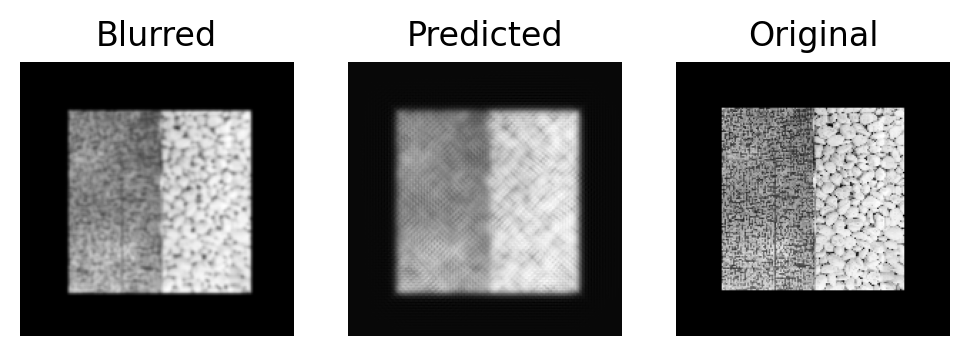

In [ ]:
model = model.to("cpu")
model.eval()
X, y = next(iter(dataloader))

y_pred = model(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,0,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Original')

In [ ]:
model.w_flat

Parameter containing:
tensor([ 0.1528,  0.0349,  0.0487,  0.1615,  0.0672, -0.1349,  0.0342,  0.0608,
        -0.1297, -0.4647, -0.0937,  0.0513,  0.0196, -0.0997,  0.2008],
       requires_grad=True)

In [ ]:
model.scale

Parameter containing:
tensor([0.6880], requires_grad=True)